# Langfuse for CICD with RAG - Part 2
* Notebook by Adam Lang
* Date: 12/26/2024

# Overview
* This notebook is part 2 of how to utilize Langfuse for LLMOps, focusing on RAG. 
* First thing you need to do is Setup a Langfuse project and get credentials by going to the Langfuse dashboard link: cloud.langfuse.com
* After doing that, follow steps in dashboard to create a new org --> new project --> Get API key.
* Then create a secret .env file with the langfuse credentials, then you can proceed!

In [ ]:
# ! pip install -r ../../requirements.txt

In [1]:
import dotenv

dotenv.load_dotenv('.env')

True

## Fetching prompt from Langfuse
* Below we will fetch one of our production prompts from Langfuse.
* A note below about the parameter `cache_ttl_seconds`. It is important to set the cache because we want to cache prompts that have already been used so we don't keep pinging Langfuse for them.
  * We can set a smaller cache limit if needed.

In [2]:
from langfuse import Langfuse

# create Langfuse object
langfuse = Langfuse()

## fetch prompt directly from Langfuse 
langfuse_prompt = langfuse.get_prompt("rag-base-prompt-with-context", cache_ttl_seconds=0)
print(langfuse_prompt.prompt)

Answer this question using the provided context only.
{{question}}

Context:
{{context}}




* This is the prompt above but from where we created it in the Langfuse dashboard:

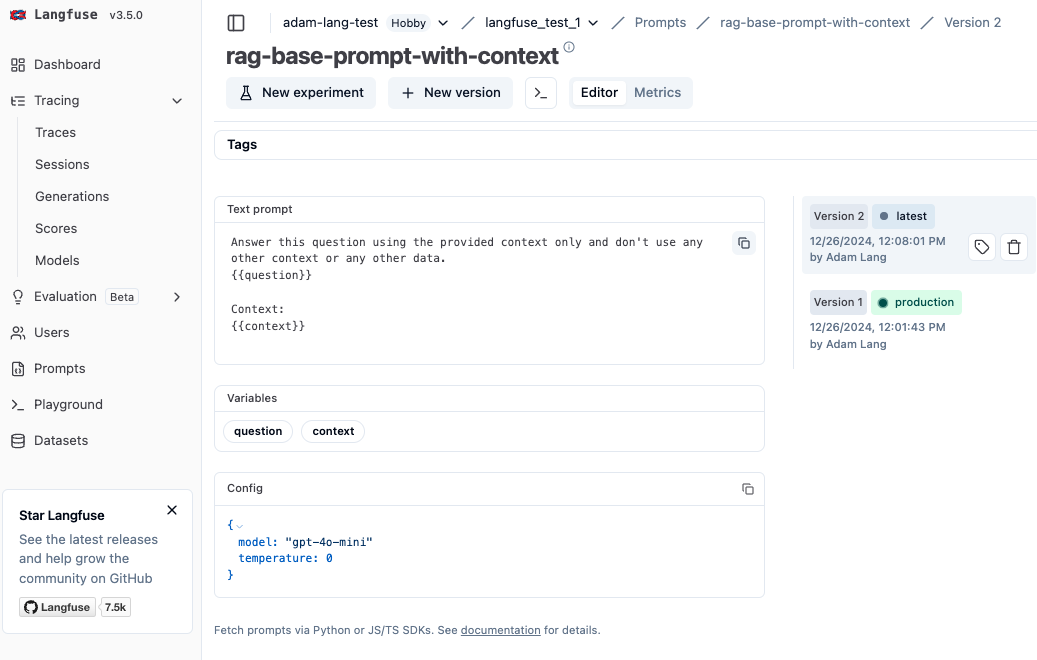

## LangChain Format
* Below we will use prompt formatting for LangChain which differs based on the number of curly braces (1 curly brace in LangChain, 2 curly braces in Langfuse)

In [3]:
online_prompt = langfuse_prompt.get_langchain_prompt()
online_prompt

'Answer this question using the provided context only.\n{question}\n\nContext:\n{context}\n\n'

### Below is the specific metadata for the prompt above

In [4]:
langfuse_prompt.config

{'model': 'gpt-4o-mini', 'temperature': 0}

# Create a Demo RAG Application
* We can create a demo RAG app to test with Langfuse below. 

## Load Data

In [5]:
from langchain_community.document_loaders import WikipediaLoader


## RAG app with Wikipedia data loader
docs = WikipediaLoader(query="Artificial intelligence", load_max_docs=2, doc_content_chars_max=1000).load()
docs

[Document(metadata={'title': 'Artificial intelligence', 'summary': 'Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs.\nHigh-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being ca

## Chunking

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

## create text_splitter for chunking documents
text_splitter=RecursiveCharacterTextSplitter(chunk_size=300,chunk_overlap=30)

## apply the text splitter to documents
documents=text_splitter.split_documents(docs)
for doc in documents[:5]:
    print(doc.page_content, "\n")
print(len(documents))

Artificial intelligence (AI), in its broadest sense, is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence 

use learning and intelligence to take actions that maximize their chances of achieving defined goals. Such machines may be called AIs. 

High-profile applications of AI include advanced web search engines (e.g., Google Search); recommendation systems (used by YouTube, Amazon, and Netflix); virtual assistants (e.g., Google Assistant, Siri, and Alexa); autonomous vehicles (e.g., Waymo); generative and creative tools (e.g., ChatGPT and 

tools (e.g., ChatGPT and AI art); and superhuman play and analysis in strategy games (e.g., chess and Go). However, many AI applications are not perceived as AI: "A lot of cutting edge AI has filtered into general applications, often without being called AI 

## Create Embeddings & Vector Store
* Embeddings creation with OpenAI
* Vector DB creation with Chroma

In [7]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(
    documents,
    embedding=OpenAIEmbeddings(),
)

## Create Retriever

In [8]:
## convert to retriever
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 2},
)

## Create LLM instance
* Notice below the LLM model value is taken from Langfuse and NOT directly from the OPENAI API. This is because we are running it through Langfuse. 

In [10]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model=langfuse_prompt.config["model"], temperature=langfuse_prompt.config["temperature"])

## Create Chat Template & Chain

In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

## Prompt Template
prompt = ChatPromptTemplate.from_template(online_prompt)


## Create RAG chain
rag_chain = {"context": retriever, "question": RunnablePassthrough()} | prompt | llm | StrOutputParser()

## Integrate LangChain with LangFuse

In [12]:
from langfuse.callback import CallbackHandler
from langfuse.decorators import langfuse_context

langfuse_handler = CallbackHandler(
    session_id="langchain-test",
    user_id="kartik@gmail.com",
    metadata={"is_notebook": True},
    tags=["lang_check"]
)
# langfuse_handler = langfuse_context.get_current_langchain_handler()
print(rag_chain.invoke("what is AI ?", config={"callbacks": [langfuse_handler]}))

# optional -- flush to langfuse cloud
langfuse_handler.flush()

Artificial intelligence (AI) is intelligence exhibited by machines, particularly computer systems. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals. AI encompasses various applications, including advanced web search engines, recommendation systems, virtual assistants, autonomous vehicles, and generative tools. The traditional goals of AI research include reasoning, knowledge representation, planning, learning, natural language processing, perception, and support for robotics.


### Tracing Results
* We can then see the output of the trace below. What we see in particular is you can drill down to what document chunks the retriever used to generate the answer. This is very helpful in evaluating the RAG pipeline.

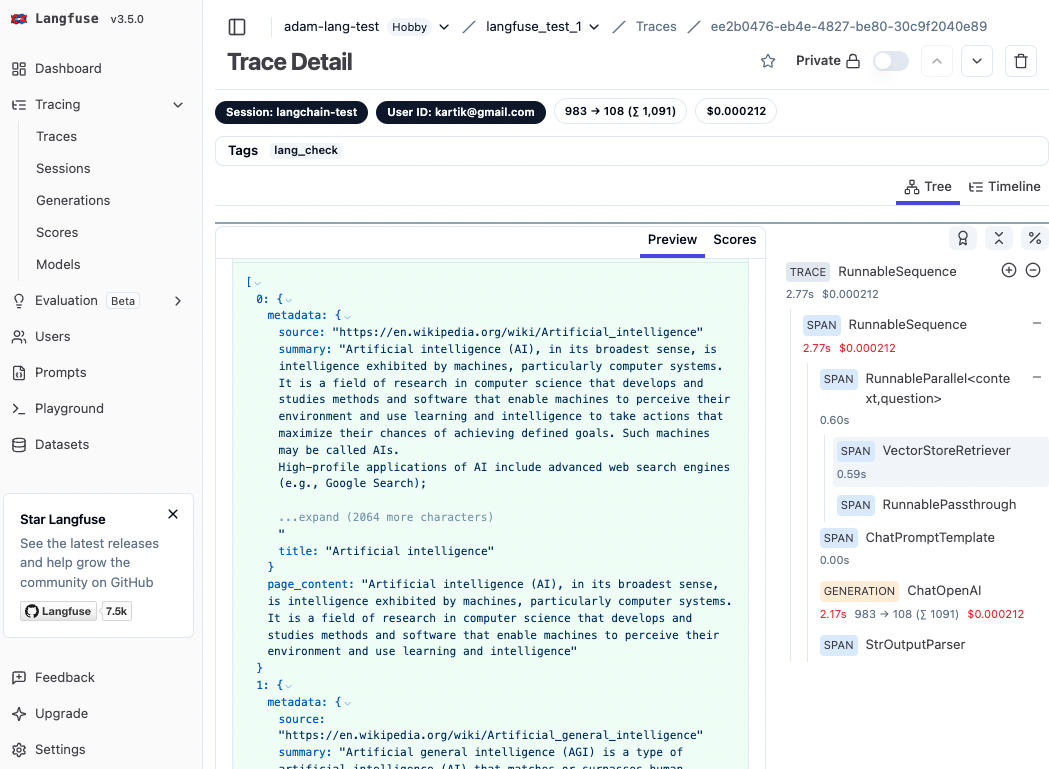

# Model based Evaluation
* A model based evaluation is often used when we want to create a custom or more specific evaluation of the LLM model outputs. 
- we can use available or a custom template
- can run evaluations based on filter criterias
- Finally we the scores are updated

In [13]:
"""
Evaluate the query's different text languages and the generation on a continuous scale from 0 to 1. A generation can be considered correct (Score: 1) if the generation language is the same as the query language.

Input:
Query: com'è il tempo in India?
Generation: The weather in India is hot and humid. Current dusty and partly cloudy conditions are expected to continue throughout the day.
Score: 0
Reasoning: The query was in Italian language but the generation was in English

Input:
Query: what is a galaxy?
Generation: A galaxy is a cluster of stars. notre soleil est un début
Score: 0.4
Reasoning: The query was in English but the generation was partially in English and partially in French

Input:
Query: {{query}}
Generation: {{generation}}

Think step by step.
"""

"""
Score between 0 and 1
Give a one word output of the query language detected
lang_check
"""

'\nScore between 0 and 1\nGive a one word output of the query language detected\nlang_check\n'

In [14]:
## creating evaluation
langfuse_handler = CallbackHandler(
    session_id="model-based-eval-check",
    user_id="kartik@gmail.com",
    metadata={"is_notebook": True},
    tags = ["lang_check"]
)
rag_chain.invoke("cosa è AI ?", config={"callbacks": [langfuse_handler]})

"L'intelligenza artificiale (AI) è, nel suo senso più ampio, l'intelligenza mostrata dalle macchine, in particolare dai sistemi informatici. È un campo di ricerca nell'informatica che sviluppa e studia metodi e software che consentono alle macchine di percepire il loro ambiente e utilizzare l'apprendimento e l'intelligenza per compiere azioni che massimizzano le loro possibilità di raggiungere obiettivi definiti. Le applicazioni di AI includono motori di ricerca avanzati, sistemi di raccomandazione, assistenti virtuali, veicoli autonomi e strumenti creativi."